In [3]:
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9e7d086/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [4]:
try:
    import viskex
except ImportError:
    !pip3 install "viskex@git+https://github.com/viskex/viskex.git@8895f22"
    import viskex

In [5]:
try:
    import multiphenicsx
except ImportError:
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@2ff1154"
    import multiphenicsx

In [6]:
import typing

In [7]:
# Import modules
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot

# Define temporal parameters
t = 0 # Start time
T = 1.0 # Final time
num_steps = 50     
dt = T / num_steps # time step size

# Define mesh
nx, ny = 50, 50
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([-2, -2]), np.array([2, 2])], 
                               [nx, ny], mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("CG", 1))

In [8]:
# Create initial condition
def initial_condition(x, a=5):
    return np.exp(-a*(x[0]**2+x[1]**2))
u_n = fem.Function(V)
u_n.name = "u_n"
u_n.interpolate(initial_condition)

# Create boundary condition
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    domain, fdim, lambda x: np.full(x.shape[1], True, dtype=bool))
bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [9]:
# Write the mesh to xdmf file
xdmf = io.XDMFFile(domain.comm, "diffusion.xdmf", "w")
xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
xdmf.write_function(uh, t)

In [10]:
import ufl

# Setup the trial (u) and Test (v) Function
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)

# Setup the forcing function
f = fem.Constant(domain, PETSc.ScalarType(0))

# Setup the bilinear form
a = u * v * ufl.dx + dt*ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx

# RHS
L = (u_n + dt * f) * v * ufl.dx

In [11]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [12]:
# Assemble the petsc matrix with appropriate boundary conditions
A = fem.petsc.assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = fem.petsc.create_vector(linear_form)

In [13]:
# Setup Krylov Subspace solver
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [14]:
# Plot the solution
import pyvista
pyvista.start_xvfb()
import matplotlib.pyplot as plt

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif")

grid.point_data["uh"] = uh.x.array
warped = grid.warp_by_scalar("uh", factor=1)

viridis = plt.cm.get_cmap("viridis", 25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(uh.x.array)])

  viridis = plt.cm.get_cmap("viridis", 25)



In [15]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    warped = grid.warp_by_scalar("uh", factor=1)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
plotter.close()
xdmf.close()

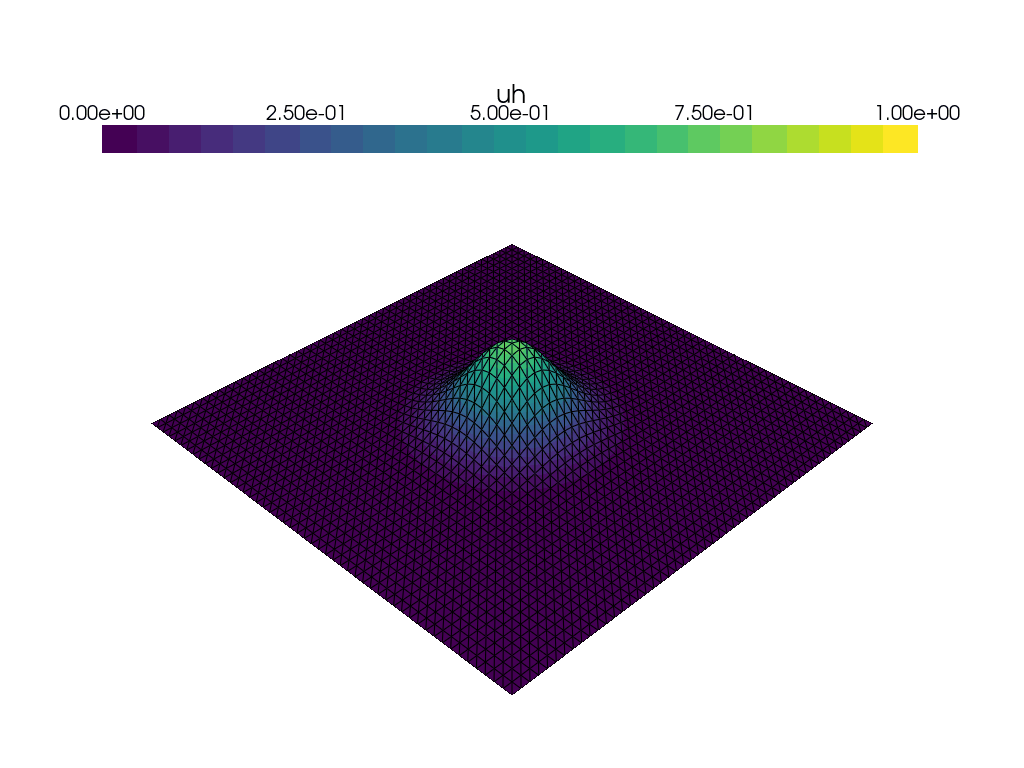

In [16]:
# Display the GIF
from IPython.display import Image
Image(open('u_time.gif','rb').read())

In [18]:
rm dif*